In [1]:
# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import numpy as np
import json
import random
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time
import timm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Define Model Architecture
# ============================================================
class SSLEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.3):
        super(SSLEfficientNet, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Linear(128, 64))
        self.classifier = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Dropout(dropout_rate * 0.5), nn.Linear(256, num_classes))
        self._initialize_weights()
    def _initialize_weights(self):
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    def forward(self, x): return self.classifier(self.backbone(x))

def create_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.3):
    return SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)

print("Model architecture defined")

Model architecture defined


In [4]:
# ============================================================
# Loss Function
# ============================================================
class WeightedFocalLoss(nn.Module):
    """Focal loss with alpha weighting to handle imbalance and prioritize positive class."""
    def __init__(self, alpha=0.9, gamma=2.0):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([1 - alpha, alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt)**self.gamma * BCE_loss
        return F_loss.mean()

print("Weighted Focal Loss function defined")

Weighted Focal Loss function defined


In [5]:
# ============================================================
# Dataset and Transform Definitions
# ============================================================
class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform_map): self.paths, self.labels, self.tm = paths, labels, transform_map
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = self.labels[idx]
        return self.tm[label](img), label

class UnlabeledDataset(Dataset):
    def __init__(self, paths, weak_tf, strong_tf): self.paths, self.weak_tf, self.strong_tf = paths, weak_tf, strong_tf
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.weak_tf(img), self.strong_tf(img)

class ValidationDataset(Dataset):
    def __init__(self, paths, labels, transform): self.paths, self.labels, self.tf = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.tf(img), self.labels[idx]

norm_params = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
strong_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30), transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(), transforms.Normalize(**norm_params)
])
moderate_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), transforms.Normalize(**norm_params)
])
weak_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(**norm_params)])
val_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(**norm_params)])

print("SSL Datasets and transforms defined")

SSL Datasets and transforms defined


In [6]:
# ============================================================
# Data Loading Function
# ============================================================
def load_and_prepare_data():
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f: data_metadata = json.load(f)
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir, unlabeled_dir = data_dir / "labeled", data_dir / "unlabeled"
    
    labeled_paths, labels = [], []
    for name, idx in {"Negative": 0, "Positive": 1}.items():
        class_dir = labeled_dir / name
        if class_dir.exists():
            for path in class_dir.glob("*.[jp][pn]g"): labeled_paths.append(str(path)); labels.append(idx)
    
    unlabeled_paths = [str(p) for p in unlabeled_dir.glob("*.[jp][pn]g")] if unlabeled_dir.exists() else []
    print(f"Loaded {len(labeled_paths)} labeled ({Counter(labels)}) and {len(unlabeled_paths)} unlabeled images.")
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels)
    
    train_dataset = LabeledDataset(train_paths, train_labels, transform_map={0: moderate_transform, 1: strong_transform})
    val_dataset = ValidationDataset(val_paths, val_labels, val_transform)
    unlabeled_dataset = UnlabeledDataset(unlabeled_paths, weak_transform, strong_transform)
    
    return train_dataset, val_dataset, unlabeled_dataset, train_labels

print("Data loading function defined")

Data loading function defined


In [7]:
# ============================================================
# Stable, Goal-Oriented Trainer Class
# ============================================================
class BalancedTrainer:
    def __init__(self, model, device='cuda', ssl_weight=1.0, confidence_thresh=0.95):
        self.model, self.device = model.to(device), device
        self.criterion = WeightedFocalLoss(alpha=0.9, gamma=2.5) # Gamma > 2 focuses more on very hard examples
        self.ssl_weight, self.confidence_thresh = ssl_weight, confidence_thresh
        # MODIFIED: Lower learning rate for more stable fine-tuning
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=1e-3)
        # MODIFIED: More stable scheduler that monitors validation performance
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)
        self.history = {'train_loss': [], 'consistency_loss': [], 'sensitivity': [], 'specificity': [], 'false_negatives': [], 'false_positives': []}
        
        self.best_clinical_score = float('inf')
        self.best_metrics = {}

    def train_epoch(self, labeled_loader, unlabeled_loader, epoch, warmup_epochs):
        self.model.train()
        total_sup_loss, total_cons_loss = 0, 0
        unlabeled_iter = iter(unlabeled_loader)
        pbar = tqdm(labeled_loader, desc=f'Epoch {epoch+1}')
        
        for labeled_images, labels in pbar:
            labeled_images, labels = labeled_images.to(self.device), labels.to(self.device)
            logits_l = self.model(labeled_images)
            sup_loss = self.criterion(logits_l, labels)
            total_loss = sup_loss
            
            # NEW: SSL Warm-up - only add consistency loss after a few epochs
            if epoch >= warmup_epochs:
                try: images_u_w, images_u_s = next(unlabeled_iter)
                except StopIteration: unlabeled_iter = iter(unlabeled_loader); images_u_w, images_u_s = next(unlabeled_iter)
                images_u_w, images_u_s = images_u_w.to(self.device), images_u_s.to(self.device)
                
                with torch.no_grad():
                    logits_u_w = self.model(images_u_w)
                    max_probs, p_targets = torch.max(F.softmax(logits_u_w, dim=1), dim=1)
                    mask = max_probs.ge(self.confidence_thresh).float()
                
                logits_u_s = self.model(images_u_s)
                cons_loss = (F.cross_entropy(logits_u_s, p_targets, reduction='none') * mask).mean()
                total_loss += self.ssl_weight * cons_loss
                total_cons_loss += cons_loss.item()
            
            self.optimizer.zero_grad(); total_loss.backward(); self.optimizer.step()
            total_sup_loss += sup_loss.item()
            pbar.set_postfix({'sup_loss': f'{sup_loss.item():.3f}', 'cons_loss': f'{total_cons_loss / (len(pbar) or 1):.3f}'})
        
        return total_sup_loss / len(labeled_loader), total_cons_loss / len(labeled_loader)

    def validate_and_find_threshold(self, val_loader, fn_target=1, fp_target=4):
        self.model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                logits = self.model(images.to(self.device))
                all_probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
                all_labels.extend(labels.numpy())
        all_probs, all_labels = np.array(all_probs), np.array(all_labels)
        
        best_threshold, best_fp, best_fn = -1, float('inf'), float('inf')
        
        candidate_thresholds = []
        for threshold in np.arange(0.05, 1.0, 0.01):
            preds = (all_probs > threshold).astype(int)
            fn = np.sum((all_labels == 1) & (preds == 0))
            fp = np.sum((all_labels == 0) & (preds == 1))
            if fn <= fn_target and fp <= fp_target:
                candidate_thresholds.append(threshold)
        
        if candidate_thresholds:
             # Among clinically acceptable thresholds, find the one that minimizes total errors
            for threshold in candidate_thresholds:
                fp = np.sum((all_labels == 0) & ((all_probs >= threshold).astype(int) == 1))
                if fp < best_fp:
                    best_fp = fp
                    best_threshold = threshold
        else: # Fallback if target zone not met
            for threshold in np.arange(0.05, 1.0, 0.01):
                fn = np.sum((all_labels == 1) & ((all_probs < threshold).astype(int) == 1))
                fp = np.sum((all_labels == 0) & ((all_probs >= threshold).astype(int) == 1))
                if fn < best_fn or (fn == best_fn and fp < best_fp):
                    best_fn, best_fp, best_threshold = fn, fp, threshold
        
        y_pred = (all_probs >= best_threshold).astype(int)
        tp = np.sum((all_labels == 1) & (y_pred == 1)); fn_final = np.sum((all_labels == 1) & (y_pred == 0))
        tn = np.sum((all_labels == 0) & (y_pred == 0)); fp_final = np.sum((all_labels == 0) & (y_pred == 1))
        metrics = {'sensitivity': tp/(tp+fn_final) if tp+fn_final>0 else 0, 'specificity': tn/(tn+fp_final) if tn+fp_final>0 else 0, 'false_negatives': fn_final, 'false_positives': fp_final}
        return metrics, best_threshold

    def train(self, labeled_loader, unlabeled_loader, val_loader, epochs=50, warmup_epochs=5):
        print("\n" + "="*60); print("STARTING GOAL-ORIENTED SSL TRAINING"); print("="*60)
        patience, max_patience = 0, 15
        
        for epoch in range(epochs):
            train_loss, cons_loss = self.train_epoch(labeled_loader, unlabeled_loader, epoch, warmup_epochs)
            metrics, threshold = self.validate_and_find_threshold(val_loader, fn_target=1, fp_target=4)
            
            fn, fp = metrics['false_negatives'], metrics['false_positives']
            
            # MODIFIED: Scheduler now monitors a validation metric (the clinical score)
            current_score = (fn * 5) + fp 
            self.scheduler.step(current_score)
            
            for key, value in metrics.items(): self.history[key].append(value)
            self.history['train_loss'].append(train_loss); self.history['consistency_loss'].append(cons_loss)
            
            print(f"\nEpoch {epoch+1}/{epochs} | Sens: {metrics['sensitivity']:.3f}, Spec: {metrics['specificity']:.3f}, FN: {fn}, FP: {fp}, Thr: {threshold:.3f}")

            is_clinically_acceptable = fn <= 1 and fp <= 4

            is_best = False
            if is_clinically_acceptable:
                if not self.best_metrics.get('is_clinically_acceptable', False) or current_score < self.best_clinical_score:
                    is_best = True
            elif not self.best_metrics.get('is_clinically_acceptable', False) and current_score < self.best_clinical_score:
                is_best = True

            if is_best:
                self.best_clinical_score = current_score
                self.best_metrics = {**metrics, 'is_clinically_acceptable': is_clinically_acceptable}
                patience = 0
                checkpoint = {'epoch': epoch, 'model_state_dict': self.model.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict(), 'metrics': metrics, 'threshold': threshold, 'history': self.history}
                torch.save(checkpoint, 'artifacts/balanced_sensitivity_model.pth')
                print(f"  ✓ Saved best model (FN: {fn}, FP: {fp}, Score: {current_score})")
            else:
                patience += 1
            
            if (patience >= max_patience and epoch > 10) or (self.best_metrics.get('is_clinically_acceptable', False) and epoch > 10):
                print(f"\n{'✓ CLINICAL TARGET MET' if self.best_metrics.get('is_clinically_acceptable', False) else 'Early stopping'}!")
                break
        
        print("\n" + "="*60); print("TRAINING COMPLETED"); print(f"Best Results: {self.best_metrics}"); print("="*60)
        return self.history

print("Stable, Goal-Oriented Trainer defined")

Stable, Goal-Oriented Trainer defined


In [8]:
# ============================================================
# Visualization Functions
# ============================================================
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Goal-Oriented SSL Training Progress', fontsize=16, fontweight='bold')
    
    axes[0, 0].plot(history['train_loss'], label='Supervised Loss'); axes[0, 0].plot(history['consistency_loss'], label='Consistency Loss', linestyle='--');
    axes[0, 0].set_title('Training Loss Components'); axes[0, 0].legend()
    
    axes[0, 1].plot(history['sensitivity'], label='Sensitivity', color='g'); axes[0, 1].plot(history['specificity'], label='Specificity', color='b');
    axes[0, 1].set_title('Sensitivity vs Specificity'); axes[0, 1].legend()

    axes[1, 0].plot(history['false_negatives'], label='False Negatives', color='r', marker='o');
    axes[1, 0].set_title('False Negatives per Epoch'); axes[1, 0].legend()
    
    axes[1, 1].plot(history['false_positives'], label='False Positives', color='orange', marker='s');
    axes[1, 1].set_title('False Positives per Epoch'); axes[1, 1].legend()
    
    for ax in axes.flat: ax.set_xlabel('Epoch'); ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('artifacts/balanced_sensitivity_training_history.png', dpi=150)
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [9]:
# ============================================================
# Main Training Pipeline & Helper Functions
# ============================================================
def convert_numpy_to_python(obj):
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, dict): return {k: convert_numpy_to_python(v) for k, v in obj.items()}
    if isinstance(obj, list): return [convert_numpy_to_python(item) for item in obj]
    return obj

def main():
    """Main goal-oriented semi-supervised training pipeline"""
    print("="*60)
    print("SEMI-SUPERVISED LEARNING FOR OPTIMAL CLINICAL BALANCE")
    print("="*60)
    
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f: model_config = json.load(f)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    train_dataset, val_dataset, unlabeled_dataset, train_labels = load_and_prepare_data()
    
    class_counts = np.bincount(train_labels); class_weights = 1.0 / class_counts
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    labeled_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True) # Reduced batch size for stability

    print(f"\nData loader summary: Labeled Batches: {len(labeled_loader)}, Unlabeled Batches: {len(unlabeled_loader)}")
    
    model = create_model(num_classes=2, dropout_rate=0.4)
    print(f"\nModel summary: Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    pretrained_path = ARTIFACTS_DIR / "ssl_model_best_010_78.9.pth"
    if pretrained_path.exists():
        print(f"Loading pretrained weights from: {pretrained_path}")
        checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("✓ Pretrained weights loaded")
    
    trainer = BalancedTrainer(model, device=device, ssl_weight=1.0, confidence_thresh=0.95)
    history = trainer.train(labeled_loader, unlabeled_loader, val_loader, epochs=50, warmup_epochs=5)
    
    plot_training_history(history)
    
    history_serializable = convert_numpy_to_python(history)
    with open(ARTIFACTS_DIR / "balanced_sensitivity_training_history.json", "w") as f:
        json.dump(history_serializable, f, indent=2)
    
    print("\n" + "="*60); print("TRAINING COMPLETED SUCCESSFULLY"); print("="*60)
    print(f"Model saved to: artifacts/balanced_sensitivity_model.pth")
    print(f"History saved to: artifacts/balanced_sensitivity_training_history.json")
    print(f"Plots saved to: artifacts/balanced_sensitivity_training_history.png")
    
    return trainer, history

SEMI-SUPERVISED LEARNING FOR OPTIMAL CLINICAL BALANCE
Using device: cpu
Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.

Data loader summary: Labeled Batches: 10, Unlabeled Batches: 200

Model summary: Total trainable parameters: 4,705,086
Loading pretrained weights from: artifacts\ssl_model_best_010_78.9.pth
✓ Pretrained weights loaded

STARTING GOAL-ORIENTED SSL TRAINING


Epoch 1: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it, sup_loss=0.002, cons_loss=0.000]



Epoch 1/50 | Sens: 0.850, Spec: 0.722, FN: 3, FP: 5, Thr: 0.130
  ✓ Saved best model (FN: 3, FP: 5, Score: 20)


Epoch 2: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it, sup_loss=0.010, cons_loss=0.000]



Epoch 2/50 | Sens: 0.850, Spec: 0.722, FN: 3, FP: 5, Thr: 0.150


Epoch 3: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it, sup_loss=0.002, cons_loss=0.000]



Epoch 3/50 | Sens: 0.850, Spec: 0.722, FN: 3, FP: 5, Thr: 0.110


Epoch 4: 100%|██████████| 10/10 [00:40<00:00,  4.01s/it, sup_loss=0.001, cons_loss=0.000]



Epoch 4/50 | Sens: 0.850, Spec: 0.722, FN: 3, FP: 5, Thr: 0.170


Epoch 5: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it, sup_loss=0.069, cons_loss=0.000]



Epoch 5/50 | Sens: 0.850, Spec: 0.778, FN: 3, FP: 4, Thr: 0.170
  ✓ Saved best model (FN: 3, FP: 4, Score: 19)


Epoch 6: 100%|██████████| 10/10 [02:14<00:00, 13.42s/it, sup_loss=0.159, cons_loss=0.015]



Epoch 6/50 | Sens: 0.900, Spec: 0.389, FN: 2, FP: 11, Thr: 0.050


Epoch 7: 100%|██████████| 10/10 [02:17<00:00, 13.78s/it, sup_loss=0.000, cons_loss=0.025]



Epoch 7/50 | Sens: 0.900, Spec: 0.444, FN: 2, FP: 10, Thr: 0.050


Epoch 8: 100%|██████████| 10/10 [02:37<00:00, 15.76s/it, sup_loss=0.000, cons_loss=0.012]



Epoch 8/50 | Sens: 0.850, Spec: 0.556, FN: 3, FP: 8, Thr: 0.060


Epoch 9: 100%|██████████| 10/10 [02:34<00:00, 15.44s/it, sup_loss=0.052, cons_loss=0.028]



Epoch 9/50 | Sens: 0.850, Spec: 0.500, FN: 3, FP: 9, Thr: 0.050


Epoch 10: 100%|██████████| 10/10 [02:20<00:00, 14.04s/it, sup_loss=0.018, cons_loss=0.023]



Epoch 10/50 | Sens: 0.850, Spec: 0.500, FN: 3, FP: 9, Thr: 0.060


Epoch 11: 100%|██████████| 10/10 [02:43<00:00, 16.36s/it, sup_loss=0.038, cons_loss=0.027]



Epoch 11/50 | Sens: 0.800, Spec: 0.556, FN: 4, FP: 8, Thr: 0.050


Epoch 12: 100%|██████████| 10/10 [02:35<00:00, 15.57s/it, sup_loss=0.011, cons_loss=0.022]



Epoch 12/50 | Sens: 0.800, Spec: 0.556, FN: 4, FP: 8, Thr: 0.050


Epoch 13: 100%|██████████| 10/10 [02:26<00:00, 14.68s/it, sup_loss=0.011, cons_loss=0.031]



Epoch 13/50 | Sens: 0.800, Spec: 0.667, FN: 4, FP: 6, Thr: 0.070


Epoch 14: 100%|██████████| 10/10 [02:19<00:00, 13.90s/it, sup_loss=0.049, cons_loss=0.013]



Epoch 14/50 | Sens: 0.750, Spec: 0.722, FN: 5, FP: 5, Thr: 0.060


Epoch 15: 100%|██████████| 10/10 [02:35<00:00, 15.51s/it, sup_loss=0.045, cons_loss=0.022]



Epoch 15/50 | Sens: 0.700, Spec: 0.722, FN: 6, FP: 5, Thr: 0.070


Epoch 16: 100%|██████████| 10/10 [02:26<00:00, 14.65s/it, sup_loss=0.029, cons_loss=0.012]



Epoch 16/50 | Sens: 0.800, Spec: 0.611, FN: 4, FP: 7, Thr: 0.050


Epoch 17: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it, sup_loss=0.002, cons_loss=0.029]



Epoch 17/50 | Sens: 0.850, Spec: 0.556, FN: 3, FP: 8, Thr: 0.050


Epoch 18: 100%|██████████| 10/10 [02:22<00:00, 14.27s/it, sup_loss=0.097, cons_loss=0.039]



Epoch 18/50 | Sens: 0.850, Spec: 0.556, FN: 3, FP: 8, Thr: 0.050


Epoch 19: 100%|██████████| 10/10 [02:26<00:00, 14.62s/it, sup_loss=0.011, cons_loss=0.041]



Epoch 19/50 | Sens: 0.700, Spec: 0.667, FN: 6, FP: 6, Thr: 0.050


Epoch 20: 100%|██████████| 10/10 [02:21<00:00, 14.20s/it, sup_loss=0.015, cons_loss=0.036]



Epoch 20/50 | Sens: 0.700, Spec: 0.667, FN: 6, FP: 6, Thr: 0.050

Early stopping!

TRAINING COMPLETED
Best Results: {'sensitivity': np.float64(0.85), 'specificity': np.float64(0.7777777777777778), 'false_negatives': np.int64(3), 'false_positives': np.int64(4), 'is_clinically_acceptable': np.False_}


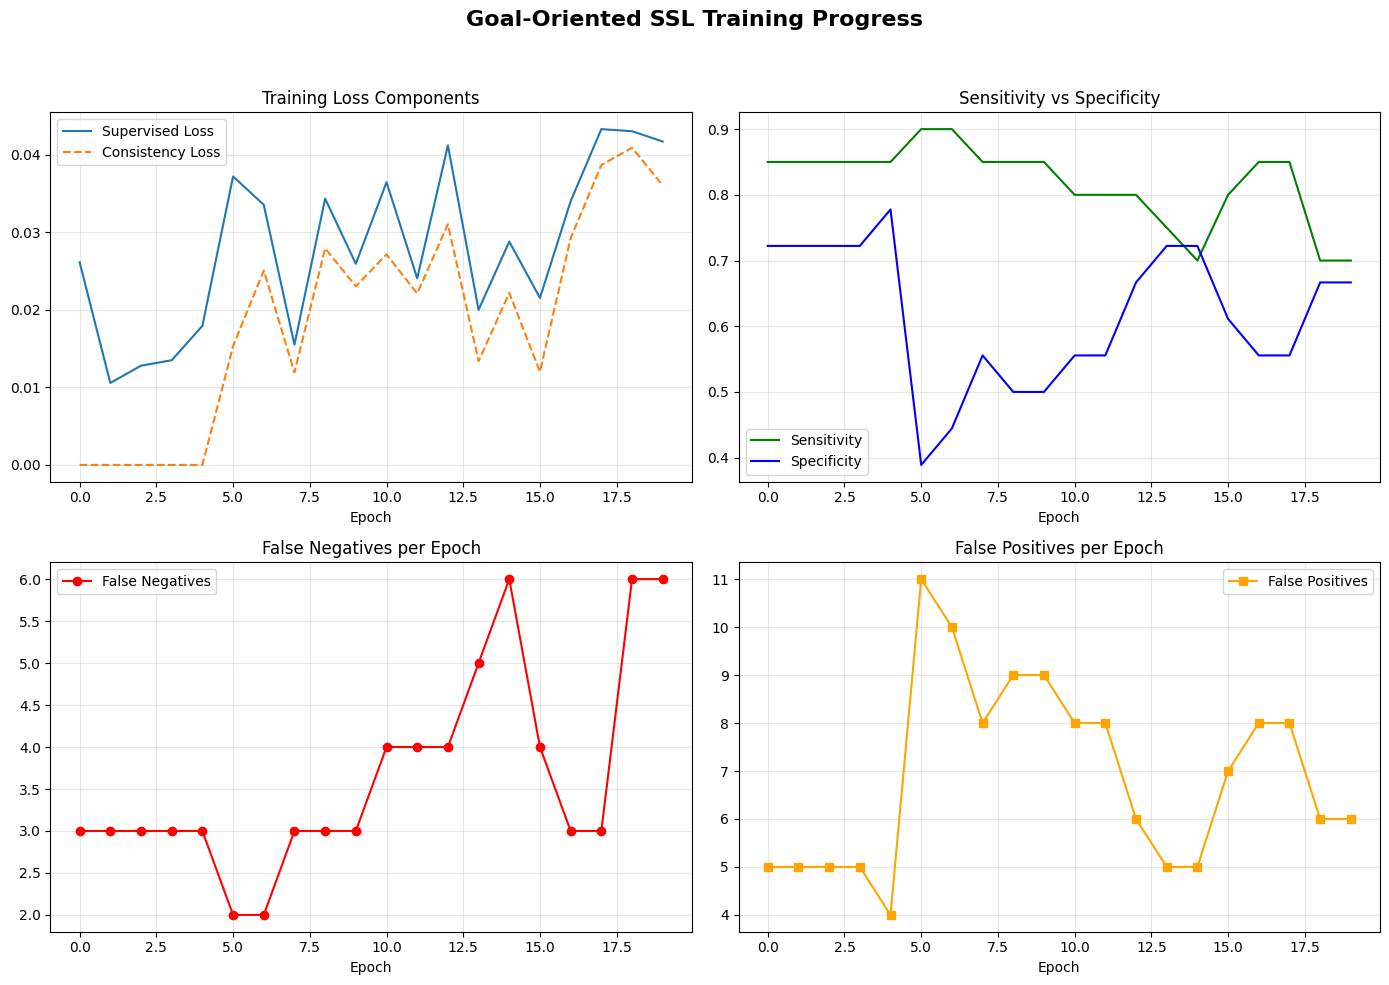


TRAINING COMPLETED SUCCESSFULLY
Model saved to: artifacts/balanced_sensitivity_model.pth
History saved to: artifacts/balanced_sensitivity_training_history.json
Plots saved to: artifacts/balanced_sensitivity_training_history.png

FINAL PERFORMANCE SUMMARY
Best Clinically-Acceptable Model Performance:
  - False Negatives: 3
  - False Positives: 4
  - Sensitivity: 0.850
  - Specificity: 0.778
  - Was Clinically Acceptable: No (Best Effort)


In [10]:
# ============================================================
# Execute Training
# ============================================================
if __name__ == "__main__":
    trainer, history = main()
    
    # Print final summary
    print("\n" + "="*60)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*60)
    if trainer.best_metrics:
        best_metrics = trainer.best_metrics
        print(f"Best Clinically-Acceptable Model Performance:")
        print(f"  - False Negatives: {best_metrics['false_negatives']}")
        print(f"  - False Positives: {best_metrics['false_positives']}")
        print(f"  - Sensitivity: {best_metrics['sensitivity']:.3f}")
        print(f"  - Specificity: {best_metrics['specificity']:.3f}")
        print(f"  - Was Clinically Acceptable: {'Yes' if best_metrics.get('is_clinically_acceptable') else 'No (Best Effort)'}")
    else:
        print("No suitable model was saved during training.")